In [1]:
#| default_exp models.mlp

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# MLP
> One of the simplest neural architectures are Multi Layer Perceptrons (`MLP`) composed of stacked Fully Connected Neural Networks trained with backpropagation. Each node in the architecture is capable of modeling non-linear relationships granted by their activation functions. Novel activations like Rectified Linear Units (`ReLU`) have greatly improved the ability to fit deeper networks overcoming gradient vanishing problems that were associated with `Sigmoid` and `TanH` activations. For the forecasting task the last layer is changed to follow a auto-regression problem.<br><br>**References**<br>-[Rosenblatt, F. (1958). "The perceptron: A probabilistic model for information storage and organization in the brain."](https://psycnet.apa.org/record/1959-09865-001)<br>-[Fukushima, K. (1975). "Cognitron: A self-organizing multilayered neural network."](https://pascal-francis.inist.fr/vibad/index.php?action=getRecordDetail&idt=PASCAL7750396723)<br>-[Vinod Nair, Geoffrey E. Hinton (2010). "Rectified Linear Units Improve Restricted Boltzmann Machines"](https://www.cs.toronto.edu/~fritz/absps/reluICML.pdf)<br>

![Figure 1. Three layer MLP with autorregresive inputs.](imgs_models/mlp.png)

In [3]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [4]:
#| export
from typing import Optional

import torch
import torch.nn as nn

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.common._modules import Concentrator

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#| export
class MLP(BaseWindows):
    """ MLP

    Simple Multi Layer Perceptron architecture (MLP). 
    This deep neural network has constant units through its layers, each with
    ReLU non-linearities, it is trained using ADAM stochastic gradient descent.
    The network accepts static, historic and future exogenous data, flattens 
    the inputs and learns fully connected relationships against the target variable.

    **Parameters:**<br>
    `h`: int, forecast horizon.<br>
    `input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>    
    `n_layers`: int, number of layers for the MLP.<br>
    `hidden_size`: int, number of units for each layer of the MLP.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of differentseries in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
    `windows_batch_size`: int=None, windows sampled from rolled data, if None uses all.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    
    """
    def __init__(self,
                 h,
                 input_size,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,                 
                 num_layers = 2,
                 hidden_size = 1024,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 # New parameters
                 use_concentrator: bool = False,
                 concentrator_type: str = None,
                 n_series: int = 1,
                 treatment_var_name: str = "treatment",
                 freq: int=1,
                 **trainer_kwargs,
                 ):

        # Inherit BaseWindows class
        super(MLP, self).__init__(h=h,
                                  input_size=input_size,
                                  futr_exog_list=futr_exog_list,
                                  hist_exog_list=hist_exog_list,
                                  stat_exog_list=stat_exog_list,                                  
                                  loss=loss,
                                  valid_loss=valid_loss,
                                  max_steps=max_steps,
                                  learning_rate=learning_rate,
                                  num_lr_decays=num_lr_decays,
                                  early_stop_patience_steps=early_stop_patience_steps,
                                  val_check_steps=val_check_steps,
                                  batch_size=batch_size,
                                  valid_batch_size=valid_batch_size,
                                  windows_batch_size=windows_batch_size,
                                  step_size=step_size,
                                  scaler_type=scaler_type,
                                  num_workers_loader=num_workers_loader,
                                  drop_last_loader=drop_last_loader,
                                  random_seed=random_seed,
                                  **trainer_kwargs)

        # ------------------ Concentrator ------------------
        # Asserts
        if use_concentrator:
            assert (
                treatment_var_name in hist_exog_list
            ), f"Variable {treatment_var_name} not found in hist_exog_list!"
            assert (
                hist_exog_list[-1] == treatment_var_name
            ), f"Variable {treatment_var_name} must be the last element of hist_exog_list!"

        self.use_concentrator = use_concentrator

        if self.use_concentrator:
            self.concentrator = Concentrator(
                n_series=n_series,
                type=concentrator_type,
                treatment_var_name=treatment_var_name,
                input_size=input_size,
                freq=freq,
                h=h,
                mask_future=False
            )
        else:
            self.concentrator = None
        # --------------------------------------------------

        # Architecture
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.futr_input_size = len(self.futr_exog_list)
        self.hist_input_size = len(self.hist_exog_list)
        self.stat_input_size = len(self.stat_exog_list)

        input_size_first_layer = input_size + self.hist_input_size * input_size + \
                                 self.futr_input_size*(input_size + h) + self.stat_input_size

        # MultiLayer Perceptron
        layers = [nn.Linear(in_features=input_size_first_layer, out_features=hidden_size)]
        for i in range(num_layers - 1):
            layers += [nn.Linear(in_features=hidden_size, out_features=hidden_size)]
        self.mlp = nn.ModuleList(layers)

        # Adapter with Loss dependent dimensions
        self.out = nn.Linear(in_features=hidden_size, 
                             out_features=h * self.loss.outputsize_multiplier)

    def forward(self, windows_batch):

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']
        batch_idx     = windows_batch['batch_idx']
        
        if self.use_concentrator:
            hist_exog = self.concentrator(treatment_exog=hist_exog,
                                stat_exog=stat_exog,
                                idx=batch_idx)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_input_size > 0:
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_input_size > 0:
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_input_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)

        y_pred = insample_y.clone()
        for layer in self.mlp:
             y_pred = torch.relu(layer(y_pred))
        y_pred = self.out(y_pred)
        y_pred = self.loss.domain_map(y_pred)
        return y_pred

In [6]:
show_doc(MLP)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/mlp.py#L17){target="_blank" style="float:right; font-size:smaller"}

### MLP

>      MLP (h, input_size, futr_exog_list=None, hist_exog_list=None,
>           stat_exog_list=None, num_layers=2, hidden_size=1024, loss=MAE(),
>           valid_loss=None, max_steps:int=1000, learning_rate:float=0.001,
>           num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>           val_check_steps:int=100, batch_size:int=32,
>           valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>           step_size:int=1, scaler_type:str='identity', random_seed:int=1,
>           num_workers_loader:int=0, drop_last_loader:bool=False,
>           use_concentrator:bool=False, concentrator_type:str=None,
>           n_series:int=1, treatment_var_name:str='treatment', freq:int=1,
>           **trainer_kwargs)

MLP

Simple Multi Layer Perceptron architecture (MLP). 
This deep neural network has constant units through its layers, each with
ReLU non-linearities, it is trained using ADAM stochastic gradient descent.
The network accepts static, historic and future exogenous data, flattens 
the inputs and learns fully connected relationships against the target variable.

**Parameters:**<br>
`h`: int, forecast horizon.<br>
`input_size`: int, considered autorregresive inputs (lags), y=[1,2,3,4] input_size=2 -> lags=[1,2].<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>    
`n_layers`: int, number of layers for the MLP.<br>
`hidden_size`: int, number of units for each layer of the MLP.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of differentseries in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch.<br>
`windows_batch_size`: int=None, windows sampled from rolled data, if None uses all.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| h |  |  |  |
| input_size |  |  |  |
| futr_exog_list | NoneType | None |  |
| hist_exog_list | NoneType | None |  |
| stat_exog_list | NoneType | None |  |
| num_layers | int | 2 |  |
| hidden_size | int | 1024 |  |
| loss | MAE | MAE() |  |
| valid_loss | NoneType | None |  |
| max_steps | int | 1000 |  |
| learning_rate | float | 0.001 |  |
| num_lr_decays | int | -1 |  |
| early_stop_patience_steps | int | -1 |  |
| val_check_steps | int | 100 |  |
| batch_size | int | 32 |  |
| valid_batch_size | Optional | None |  |
| windows_batch_size | int | 1024 |  |
| step_size | int | 1 |  |
| scaler_type | str | identity |  |
| random_seed | int | 1 |  |
| num_workers_loader | int | 0 |  |
| drop_last_loader | bool | False |  |
| use_concentrator | bool | False | New parameters |
| concentrator_type | str | None |  |
| n_series | int | 1 |  |
| treatment_var_name | str | treatment |  |
| freq | int | 1 |  |
| trainer_kwargs |  |  |  |

In [7]:
show_doc(MLP.fit, name='MLP.fit')

---

### MLP.fit

>      MLP.fit (dataset, val_size=0, test_size=0)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [8]:
show_doc(MLP.predict, name='MLP.predict')

---

### MLP.predict

>      MLP.predict (dataset, test_size=None, step_size=1, **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

In [9]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.48it/s]


<AxesSubplot:xlabel='ds'>

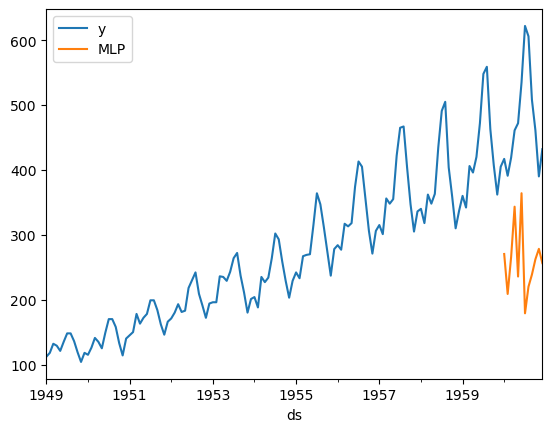

In [10]:
#| hide
# test performance fit/predict method
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset


Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
model = MLP(h=12, input_size=24, max_steps=1)
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)
Y_test_df['MLP'] = y_hat

#test we recover the same forecast
y_hat2 = model.predict(dataset=dataset)
test_eq(y_hat, y_hat2)

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [11]:
#| hide
# test no leakage with test_size
dataset, *_ = TimeSeriesDataset.from_df(Y_df)
model = MLP(h=12, input_size=24, max_steps=1)
model.fit(dataset=dataset, test_size=12)
y_hat_test = model.predict(dataset=dataset, step_size=1)
np.testing.assert_almost_equal(
    y_hat, 
    y_hat_test,
    decimal=4
)
# test we recover the same forecast
y_hat_test2 = model.predict(dataset=dataset, step_size=1)
test_eq(y_hat_test, y_hat_test2)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.06it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.09it/s]


<AxesSubplot:xlabel='ds'>

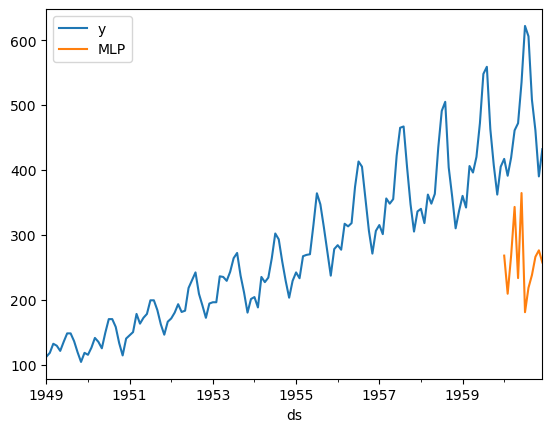

In [12]:
#| hide
# test validation step
dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
model = MLP(h=12, input_size=24, step_size=1, 
            hidden_size=1024, num_layers=2,
            max_steps=1)
model.fit(dataset=dataset, val_size=12)
y_hat_w_val = model.predict(dataset=dataset)
Y_test_df['MLP'] = y_hat_w_val

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [13]:
#| hide
# test no leakage with test_size and val_size
dataset, *_ = TimeSeriesDataset.from_df(Y_df)
model = MLP(h=12, input_size=24, step_size=1, 
            hidden_size=1024, num_layers=2,
            max_steps=1)
model.fit(dataset=dataset, val_size=12, test_size=12)
y_hat_test_w_val = model.predict(dataset=dataset, step_size=1)
np.testing.assert_almost_equal(y_hat_test_w_val,
                               y_hat_w_val, decimal=4)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.11it/s]


# Concentrator

In [14]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic


Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

# TREATMENT
Y_train_df['treatment'] = 0
Y_test_df['treatment'] = 0

Y_train_df['treatment'].iloc[50] = 1
Y_train_df['treatment'].iloc[100] = 1
Y_train_df['treatment'].iloc[220] = 1

Y_train_df.head()

,unique_id,ds,y,trend,y_[lag12],treatment
0,Airline1,1949-01-31,112.0,0,112.0,0
1,Airline1,1949-02-28,118.0,1,118.0,0
2,Airline1,1949-03-31,132.0,2,132.0,0
3,Airline1,1949-04-30,129.0,3,129.0,0
4,Airline1,1949-05-31,121.0,4,121.0,0


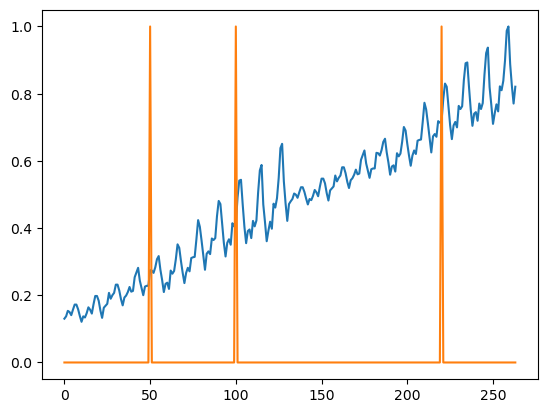

In [15]:
#| eval: false
plt.plot(Y_train_df['y'].values/Y_train_df['y'].max())
plt.plot(Y_train_df['treatment'].values)

In [16]:
#| eval: false
model = MLP(h=12,
            input_size=24,
            scaler_type='robust',
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'],
            learning_rate=1e-3,
            max_steps=200,
            val_check_steps=10,
            early_stop_patience_steps=2,
            # RELEVANT FOR TREATMENT:
            hist_exog_list=['treatment'],
            use_concentrator=True,
            batch_size=2,
            n_series=2,
            concentrator_type='log_normal',
            treatment_var_name='treatment',
            freq = 5)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.18it/s]


[]

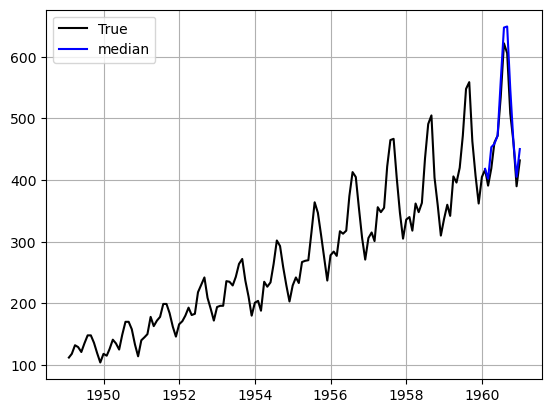

In [17]:
#| eval: false
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['MLP'], c='blue', label='median')
plt.legend()
plt.grid()
plt.plot()

In [18]:
#| eval: false
model.concentrator.k_a.weight

Parameter containing:
tensor([[0.4681],
        [0.5262]], requires_grad=True)